<h1 STYLE="padding-left:1em;text-align: center;">Projet 05 : Catégorisez automatiquement des questions </h1> 

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Dans ce projet, nous allons proposer une analyse textuelle des questions posées sur le site de 'Stackoverflow' afin de développer un système de suggestion de tag pour le site. Celui-ci prendra la forme d'un algorithme de machine learning qui assignera automatiquement plusieurs tags à une question posée. 

<p STYLE="padding-left:1em;text-align:justify;">Ce notebook contient le code final à déployer 

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et des fonctions graphiques</b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Importation des données et sélection des variables pertinentes</b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Approche non supervisée</b></a><br>
<a href="#3.1" STYLE="padding-left:2em;color:black">3.1 Latent Dirichlet Allocation</a><br>
<a href="#3.1.1" STYLE="padding-left:3em;color:black">3.1.1 Librairie Scikit-Learn</a><br>
<a href="#3.1.1a" STYLE="padding-left:4em;color:black">3.1.1a Bag of words</a><br>
<a href="#3.1.1b" STYLE="padding-left:4em;color:black">3.1.1b TF-IDF</a><br>
<a href="#3.1.2" STYLE="padding-left:3em;color:black">3.1.2 Librairie gensim</a><br>
<a href="#3.1.2a" STYLE="padding-left:4em;color:black">3.1.2a Bag of words</a><br>
<a href="#3.1.2b" STYLE="padding-left:4em;color:black">3.1.2b TF-IDF</a><br>
<a href="#3.2" STYLE="padding-left:2em;color:black">3.2 Non-Negative Matrix Factorization (NMF)</a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : Approche supervisée</b></a><br>
<a href="#4.1" STYLE="padding-left:2em;color:black">4.1 Réduction dimensionnelle PCA</a><br>
<a href="#4.1.1" STYLE="padding-left:3em;color:black">4.1.1 Bag of words</a><br>
<a href="#4.1.2" STYLE="padding-left:3em;color:black">4.1.2 TF-IDF</a><br>
<a href="#4.2" STYLE="padding-left:2em;color:black">4.2 Tests de modèles de classification</a><br>
<a href="#4.2.1" STYLE="padding-left:3em;color:black">4.2.1 Bag of words</a><br>
<a href="#4.2.2" STYLE="padding-left:3em;color:black">4.2.2 TF-IDF</a><br>


# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et des fonctions graphiques 

In [1]:
%matplotlib inline

import os
from pathlib import Path
import re

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

from operator import itemgetter
import collections
from collections import Counter,defaultdict

from joblib import parallel_backend, Parallel, delayed , dump , load
from joblib import wrap_non_picklable_objects
from joblib.externals.loky import set_loky_pickler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF, PCA

import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import EnsembleLda

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models 

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bud64\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bud64\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<p STYLE="padding-left:1em;color:blue;"><b>Configuration générale des différents graphiques <font>

In [2]:
plt.rcdefaults()
font_title = {'color': 'blue','weight': 'bold','size': 14}
font_label = {'size': 12}
font_ticks = 12
font_legend = 10
c = []
[c.append(plt.cm.tab20(i)) for i in range(20)]
    
def config_plt(plot = plt, ax = None, title = 'titre', X_name = 'x' , Y_name = 'y' , legend = ''):   
    if plot == plt :
        plot.title(title,fontdict=font_title)
        plot.xlabel(X_name,fontdict=font_label)
        plot.ylabel(Y_name,fontdict=font_label)
        plot.xticks(fontsize =font_ticks)
        plot.yticks(fontsize =font_ticks)
        if legend is not None:
            plot.legend(title = legend , fontsize =font_legend)
    else : 
# Sub-plot
        ax.set_title(title,fontdict=font_title)
        ax.set_xlabel(X_name,fontdict=font_label)
        ax.set_ylabel(Y_name,fontdict=font_label)
        ax.tick_params(axis='x', labelsize=font_ticks)
        ax.tick_params(axis='y', labelsize=font_ticks)
        if legend is not None: 
            ax.legend(title = legend , fontsize =font_legend)

In [3]:
def plot_line(DF, x_cols,cols, categorie= None,Nb_cols=2,marker = '',length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label'] 
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length))    
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.plot(DF[x_cols[0]],DF[cols[i]],color = c[0],marker = marker)
            else : 
                axes.plot(DF[x_cols[i]],DF[cols[i]],color = c[0],marker = marker)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.plot(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],marker = marker,label = cat)
                else : 
                    axes.plot(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],marker = marker, label = cat)
                k+=1
            legend = str(cat if label.get(cat) is None else label.get(cat))
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        axes.grid(visible=True,axis='x')
        
        (axes.set_xticks(DF[x_cols[0]]) if axes is not plt else axes.xticks(DF[x_cols[0]])) if DF[x_cols[0]].size<=15 else None 
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else [title if len([cols]) == 1 else title[i]]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show()
    
def display_scree_plot(pca):
    fig=plt.figure(figsize=(4,4))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    x_name = "rang de l'axe d'inertie"
    y_name = "pourcentage d'inertie"
    title="Eboulis des valeurs propres"
    config_plt(plot = plt , ax = None , title = title , X_name = x_name , Y_name = y_name , legend = None)
    plt.show(block=False)

# <a STYLE="color:black" id="2">Etape 2 : Importation des données 

In [4]:
from joblib import Memory

location = './Cachedir/'
mem = Memory(location,mmap_mode='r+',verbose=0)
if 'data_words_tf' not in locals():
    mem.clear(warn=False)

In [5]:
%%time
file_data_clean = os.path.abspath('')+'\\Data_Clean'

data_merge = load(file_data_clean+'\\data_merge.joblib')
DF_words_tags = load(file_data_clean+'\\DF_words_tags.joblib')

counter_word = load(file_data_clean+'\\counter_word.joblib')
counter_word_tags = load(file_data_clean+'\\counter_word_tags.joblib')
counter_tags = load(file_data_clean+'\\counter_tags.joblib')

data_words_tf = load(file_data_clean+'\\Bag_of_words.joblib').iloc[0:100]
data_words_tf_tags = load(file_data_clean+'\\Bag_of_words_tags.joblib')

data_words_tf_idf = load(file_data_clean+'\\DF_words_tf_idf.joblib').iloc[0:100]
data_words_tf_idf_tags = load(file_data_clean+'\\DF_words_tf_idf_tags.joblib')

Wall time: 2.27 s


In [6]:
data_words_tf

,able,access,add,also,another,anyone,api,app,application,appreciate,array,base,build,button,c,call,cannot,case,change,check,class,click,code,color,column,come,command,const,content,correct,could,create,current,data,date,def,default,define,different,display,div,edit,element,else,end,error,even,every,example,expect,fail,false,far,field,file,find,fine,first,fix,follow,format,found,function,get,give,go,help,however,html,http,idea,image,implement,import,include,index,input,inside,instead,int,issue,item,key,know,last,let,library,like,line,link,list,load,log,look,loop,main,make,many,message,method,model,multiple,name,need,new,next,none,null,number,object,one,open,option,order,output,package,page,part,path,please,point,possible,post,print,private,problem,process,program,project,public,python,query,question,r,read,remove,request,require,response,result,return,right,row,run,say,script,second,see,seem,select,self,server,service,set,show,simple,since,size,solution,something,source,start,still,store,string,sure,table,take,test,text,thank,thanks,thing,think,time,title,true,try,two,type,understand,update,url,use,user,value,var,variable,version,view,void,want,way,well,window,without,work,would,write,wrong
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# <a STYLE="color:black" id="3">Etape 3 : Approche non supervisée
## <a STYLE="color:black" id="3.1">3.1 Latent Dirichlet Allocation</a>
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous allons utiliser le modèle LDA (Latent Dirichlet Allocatioon) pour essayer de taguer nos questions de façon non supervisée. Ce modèle est un modèle probabiliste génératif qui permet de regrouper du texte non classifié en catégories ou sujets composées de mots.
    
## <a STYLE="padding-left:1em;color:black" id="3.1.1">3.1.1 Librairie Scikit-Learn</a> 
### <a STYLE="padding-left:2em;color:black" id="3.1.1a">3.1.1a Bag of words</a> 

In [7]:
n_topics = np.append(np.arange(2,20),[20,30 , 40 , 50 , 75 , 100])

In [8]:
@delayed
@wrap_non_picklable_objects
def fit_LDA(DF, n_components):
    lda = LDA(n_components,learning_method='online')
    model_lda = lda.fit(DF)
    lda_perplexity = lda.perplexity(DF)
    lda_score = lda.score(DF)
    return lda_perplexity , lda_score

# Fonction pour calcul parallèle de la boucle for 
def applyParallel_LDA(df, func, iteration):   
    resultat = Parallel(n_jobs=-1)(func(df , i) for i in iteration)
    lda_perplexity , lda_score = zip(*resultat)
    data = pd.DataFrame(np.array([iteration , lda_score , lda_perplexity]).T , 
                        columns = ['n_topics' , 'lda_score' , 'lda_perplexity']) 
    plot_line(data,'n_topics',['lda_score','lda_perplexity'],marker = 'o',Nb_cols=2)
    return data

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

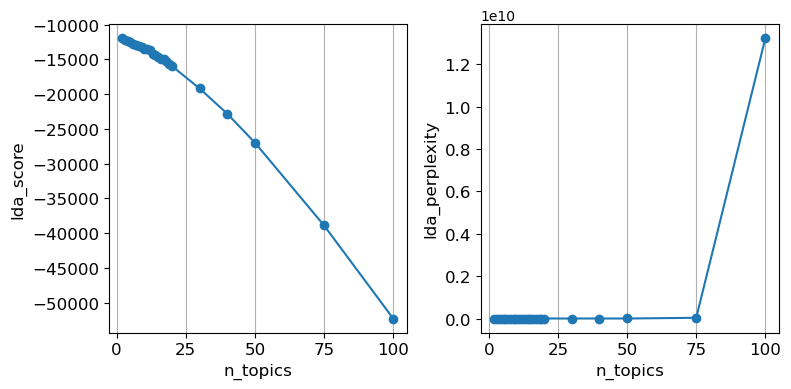

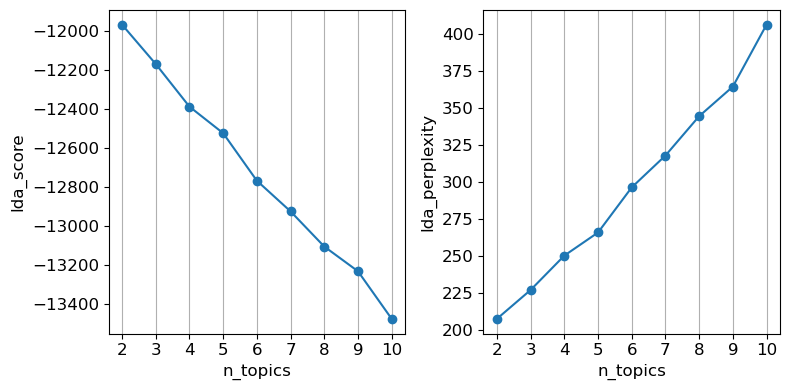

Wall time: 8.59 s


In [9]:
%%time
LDA_score  = applyParallel_LDA(data_words_tf, fit_LDA , n_topics )
plot_line(LDA_score.iloc[0:9],'n_topics',['lda_score','lda_perplexity'],marker = 'o',Nb_cols=2)

In [10]:
%%time
model_lda_best = LDA(n_components = 2 , learning_method='online',n_jobs=-1).fit(data_words_tf)
no_top_words = 10
display_topics(model_lda_best, data_words_tf.columns, no_top_words)

Topic 0:
use get need data help code one file way example
Topic 1:
try get use work code return function error c make
Wall time: 474 ms


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous observons que les scores obtenus à partir de la librairie Sklearn <span STYLE="color:gray;" ><i>(log likelihood & perplexity )</i></span>ne permettent pas d'obtenir un nombre optimal de topics.  

### <a STYLE="padding-left:2em;color:black" id="3.1.1b">3.1.1b TD-IDF</a> 

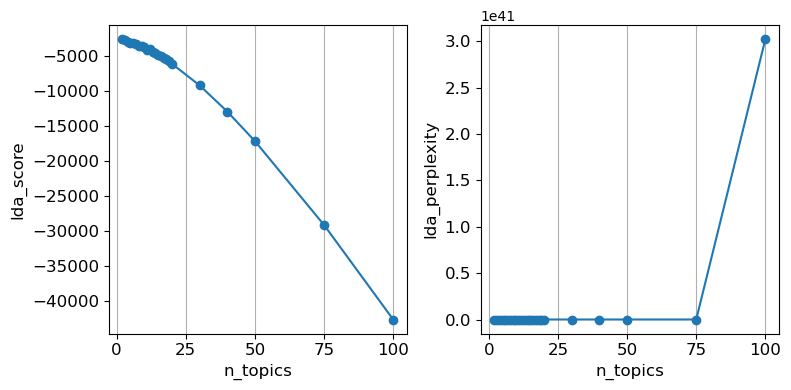

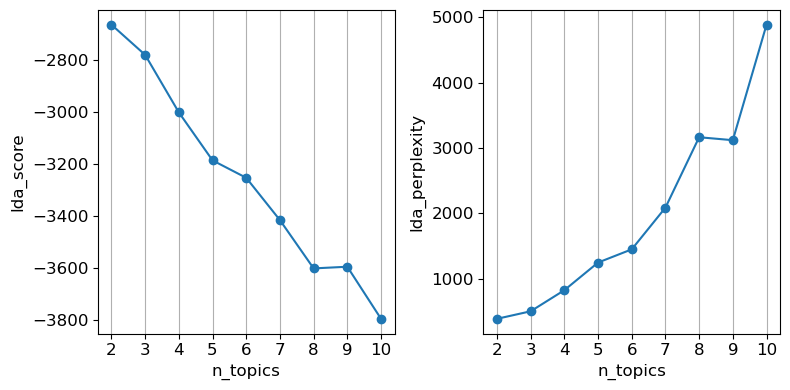

Wall time: 3.28 s


In [11]:
%%time
LDA_score_TF_IDF  = applyParallel_LDA(data_words_tf_idf, fit_LDA , n_topics )
plot_line(LDA_score_TF_IDF.iloc[0:9],'n_topics',['lda_score','lda_perplexity'],marker = 'o',Nb_cols=2)

In [12]:
%%time
model_lda_best_TF_IDF = LDA(n_components = 2 , learning_method='online',n_jobs=-1).fit(data_words_tf_idf)
no_top_words = 10
display_topics(model_lda_best_TF_IDF, data_words_tf_idf.columns, no_top_words)

Topic 0:
file data need column row api use window array set
Topic 1:
get use code try work need c like make would
Wall time: 320 ms


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous observons que les scores obtenus à partir de la librairie Sklearn <span STYLE="color:gray;" ><i>(log likelihood & perplexity )</i></span>ne permettent pas d'obtenir un nombre optimal de topics.  

## <a STYLE="padding-left:1em;color:black" id="3.1.2">3.1.2 Librairie gensim</a> 
### <a STYLE="padding-left:2em;color:black" id="3.1.2a">3.1.2a Bag of words</a> 

In [13]:
def gensim_prepocessing(DF , TF_IDF = False):
    texts =  DF.apply(lambda x : x.split()).to_list()
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    if TF_IDF == True : 
        tfidf = TfidfModel(corpus)
        corpus_out = [tfidf[t] for t in corpus]
    else :
        corpus_out = corpus
    return texts , dictionary, corpus_out

@delayed
@wrap_non_picklable_objects
def fit_LDA_gensim(corpus, dictionary , num_topics):
    model = LdaModel(corpus=corpus,id2word=dictionary,num_topics=num_topics,random_state=10)
    lda_perplexity = model.log_perplexity(corpus)
    return model , lda_perplexity 

@delayed
@wrap_non_picklable_objects
def fit_LDAMulticore_gensim(corpus, dictionary , num_topics):
    model = LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=num_topics,workers = 7 , random_state=10)
    lda_perplexity = model.log_perplexity(corpus)
    return model , lda_perplexity 

@delayed
@wrap_non_picklable_objects
def fit_coherence(model , texts, dictionary ):
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    lda_coherence = coherence_model_lda.get_coherence()      
    return lda_coherence

# Fonction pour calcul parallèle de la boucle for 
def applyParallel_LDA_gensim(DF,func, iteration , TF_IDF = False):
    texts , dictionary ,corpus = gensim_prepocessing(DF , TF_IDF = TF_IDF) 
    resultat = Parallel(n_jobs=-1)(func(corpus, dictionary , num_topics) for num_topics in iteration)
    models, lda_perplexity = zip(*resultat)
    lda_coherence = Parallel(n_jobs=-1 , prefer = 'threads')(fit_coherence(model, texts, dictionary) for model in models)

    data = pd.DataFrame(np.array([iteration , lda_coherence , lda_perplexity]).T , 
                        columns = ['n_topics' , 'lda_coherence' , 'lda_perplexity']) 
    
    plot_line(data,'n_topics',['lda_coherence','lda_perplexity'],marker = 'o',Nb_cols=2)
    return models , data

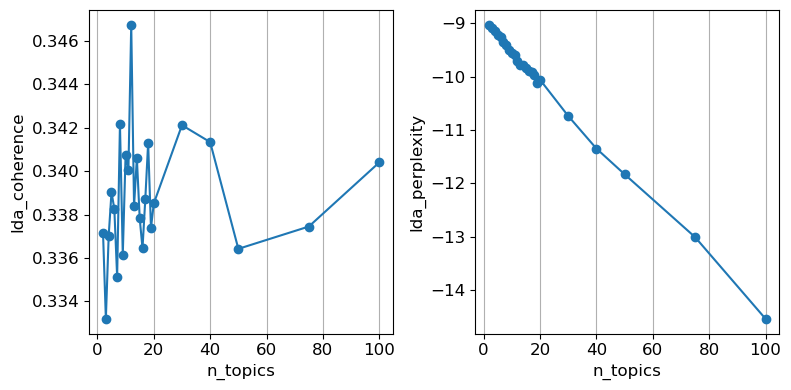

KeyError: 'coherence_lda'

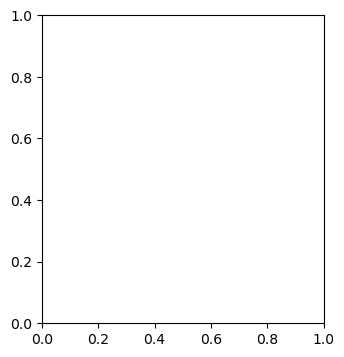

In [14]:
%%time
model_list_LDAmulticore , data_LDAmulticore_score = applyParallel_LDA_gensim(DF_words_tags.Questions,fit_LDAMulticore_gensim,n_topics)
plot_line(data_LDAmulticore_score.iloc[0:10],'n_topics',['lda_coherence','lda_perplexity'],marker = 'o',Nb_cols=2)

In [18]:
pyLDAvis.enable_notebook()
best_topics = data_LDAmulticore_score['lda_coherence'].argmax()
texts , dictionary, corpus = gensim_prepocessing(DF_words_tags.Questions)
pyLDAvis.gensim_models.prepare(model_list_LDAmulticore[best_topics], corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
6      0.04 -0.02       1        1 14.87
3     -0.02 -0.03       2        1 13.81
1     -0.00 -0.00       3        1 12.60
8     -0.02 -0.01       4        1 10.88
10     0.00  0.00       5        1  8.46
0     -0.02 -0.00       6        1  7.96
7      0.01 -0.01       7        1  7.25
11     0.01 -0.00       8        1  6.82
9     -0.02  0.00       9        1  6.01
4      0.00  0.02      10        1  5.46
5     -0.01  0.03      11        1  3.23
2      0.02  0.02      12        1  2.66, topic_info=       Term     Freq    Total Category  logprob  loglift
47     like 15250.00 15250.00  Default    30.00    30.00
55      use 26864.00 26864.00  Default    29.00    29.00
2      code 17845.00 17845.00  Default    28.00    28.00
33   return 12686.00 12686.00  Default    27.00    27.00
149    need  9873.00  9873.00  Default    26.00    26.00
..      ...      ...      ...      ...      ...      ...
37   string   205.59  8190.93  Topic12    -5.99    -0.06
60      add   210.14  8728.60  Topic12    -5.97    -0.10
5    follow   217.62  9907.56  Topic12    -5.94    -0.19
43     help   206.61  8661.17  Topic12    -5.99    -0.11
214    name   209.37  9797.01  Topic12    -5.98    -0.22

[1133 rows x 6 columns], token_table=       Topic  Freq       Term
term                         
81909      5  0.23    a.begin
81909     12  0.46    a.begin
34002     12  0.43   a.concat
6687       9  0.86      a.exe
1372       1  0.41   absolute
...      ...   ...        ...
10307     11  0.02       ymin
10307     12  0.02       ymin
4514      12  0.66      yoshi
51061     10  0.85     zoneid
51062     10  0.83  zoneid.of

[3730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 2, 9, 11, 1, 8, 12, 10, 5, 6, 3])

In [19]:
model_list_LDAmulticore[best_topics].print_topics()

[(0,
  '0.007*"get" + 0.007*"try" + 0.006*"use" + 0.006*"code" + 0.006*"new" + 0.004*"error" + 0.004*"data" + 0.004*"work" + 0.004*"want" + 0.004*"file"'),
 (1,
  '0.011*"use" + 0.007*"try" + 0.006*"want" + 0.005*"get" + 0.005*"way" + 0.005*"code" + 0.005*"one" + 0.005*"like" + 0.005*"work" + 0.004*"file"'),
 (2,
  '0.009*"use" + 0.006*"like" + 0.006*"get" + 0.006*"code" + 0.005*"need" + 0.005*"work" + 0.005*"one" + 0.005*"want" + 0.004*"function" + 0.004*"try"'),
 (3,
  '0.009*"try" + 0.008*"use" + 0.007*"work" + 0.007*"get" + 0.006*"error" + 0.006*"code" + 0.005*"want" + 0.005*"http" + 0.005*"like" + 0.004*"file"'),
 (4,
  '0.008*"use" + 0.006*"value" + 0.005*"code" + 0.005*"try" + 0.005*"work" + 0.005*"return" + 0.005*"get" + 0.004*"error" + 0.004*"class" + 0.004*"need"'),
 (5,
  '0.009*"like" + 0.006*"use" + 0.006*"try" + 0.005*"get" + 0.005*"code" + 0.005*"work" + 0.005*"type" + 0.005*"function" + 0.004*"want" + 0.004*"return"'),
 (6,
  '0.009*"use" + 0.009*"try" + 0.007*"get" + 0

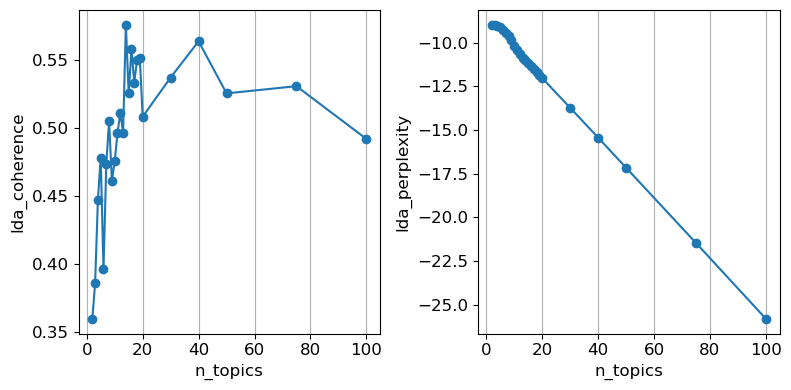

NameError: name 'data_LDA_gensim' is not defined

In [20]:
%%time
model_list_LDA_gensim  , data_LDA_gensim_score = applyParallel_LDA_gensim(DF_words_tags.Questions,fit_LDA_gensim,n_topics)
plot_line(data_LDA_gensim_score.iloc[0:10],'n_topics',['lda_coherence','lda_perplexity'],marker = 'o',Nb_cols=2)

In [21]:
pyLDAvis.enable_notebook()
best_topics = data_LDA_gensim_score['lda_coherence'].argmax()
texts , dictionary, corpus = gensim_prepocessing(DF_words_tags.Questions)
pyLDAvis.gensim_models.prepare(model_list_LDA_gensim[best_topics], corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
13    -0.34 -0.03       1        1 36.27
3     -0.27  0.11       2        1 16.31
10    -0.27 -0.17       3        1 14.82
6     -0.24 -0.10       4        1 11.54
11    -0.23  0.08       5        1 10.38
0     -0.03  0.16       6        1  3.67
9      0.01  0.01       7        1  2.15
8      0.05  0.11       8        1  1.68
7      0.12 -0.12       9        1  1.15
12     0.21  0.01      10        1  0.64
1      0.22 -0.04      11        1  0.56
4      0.25 -0.01      12        1  0.38
5      0.26 -0.01      13        1  0.23
2      0.26 -0.01      14        1  0.23, topic_info=                Term     Freq    Total Category  logprob  loglift
71             class 11116.00 11116.00  Default    30.00    30.00
33            return 15652.00 15652.00  Default    29.00    29.00
28               int  5309.00  5309.00  Default    28.00    28.00
163              app  7244.00  7244.00  Default    27.00    27.00
899           public  5261.00  5261.00  Default    26.00    26.00
...              ...      ...      ...      ...      ...      ...
16058  stopiteration     6.95     7.73  Topic14    -6.92     5.98
15120       filetype     6.96     7.74  Topic14    -6.92     5.98
7870         january    21.01    28.72  Topic14    -5.82     5.77
6776            july    18.51    27.79  Topic14    -5.94     5.68
18058       periodic     8.68    12.31  Topic14    -6.70     5.73

[953 rows x 6 columns], token_table=       Topic  Freq      Term
term                        
3639       3  0.99        ab
6743       1  0.03  accuracy
6743       2  0.01  accuracy
6743       3  0.02  accuracy
6743       9  0.94  accuracy
...      ...   ...       ...
5067       1  1.00      yaml
11748      1  0.99      yarn
20201      9  0.98      ylab
10307      9  0.98      ymin
7231      13  0.95       zsh

[3043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 4, 11, 7, 12, 1, 10, 9, 8, 13, 2, 5, 6, 3])

In [22]:
model_list_LDA_gensim[best_topics].print_topics()

[(0,
  '0.020*"public" + 0.020*"class" + 0.015*"void" + 0.015*"private" + 0.013*"string" + 0.013*"java" + 0.012*"override" + 0.010*"new" + 0.010*"static" + 0.009*"spring"'),
 (1,
  '0.004*"pycharm" + 0.004*"analyze" + 0.003*"utilize" + 0.003*"texture" + 0.003*"race" + 0.003*"markdown" + 0.003*"preferably" + 0.003*"scipy" + 0.003*"percent" + 0.003*"descend"'),
 (2,
  '0.004*"solves" + 0.004*"error.message" + 0.004*"deletes" + 0.003*"comp" + 0.003*"swipe" + 0.003*"january" + 0.003*"march" + 0.003*"february" + 0.003*"analyzer" + 0.003*"july"'),
 (3,
  '0.014*"file" + 0.013*"error" + 0.011*"run" + 0.011*"try" + 0.010*"use" + 0.009*"get" + 0.009*"http" + 0.008*"work" + 0.007*"version" + 0.006*"command"'),
 (4,
  '0.008*"mask" + 0.007*"jetpack" + 0.007*"compose" + 0.005*"modifier" + 0.005*"composable" + 0.004*"guarantee" + 0.004*"app.listen" + 0.004*"malloc" + 0.004*"reshape" + 0.004*"oct"'),
 (5,
  '0.004*"msvc" + 0.003*"zsh" + 0.003*"unrecognized" + 0.003*"sparksession" + 0.003*"getorcreat

### <a STYLE="padding-left:2em;color:black" id="3.1.2b">3.1.2b TD-IDF</a> 

In [ ]:
%%time
model_list_LDAmulticore_TF_IDF , data_LDAmulticore_TF_IDF_score = applyParallel_LDA_gensim(DF_words_tags.Questions,fit_LDAMulticore_gensim,n_topics ,TF_IDF = True )
plot_line(data_LDAmulticore_TF_IDF_score.iloc[0:10],'n_topics',['lda_coherence','lda_perplexity'],marker = 'o',Nb_cols=2)

In [ ]:
pyLDAvis.enable_notebook()
best_topics = data_LDAmulticore_TF_IDF_score['lda_coherence'].argmax()
texts_TF_IDF , dictionary_TF_IDF, corpus_TF_IDF = gensim_prepocessing(DF_words_tags.Questions, TF_IDF = True)
pyLDAvis.gensim_models.prepare(model_list_LDAmulticore_TF_IDF[best_topics], corpus_TF_IDF, dictionary_TF_IDF)

In [ ]:
model_list_LDAmulticore_TF_IDF[best_topics].print_topics()

In [ ]:
%%time
model_list_LDA_gensim_TF_IDF , data_LDA_gensim_TF_IDF = applyParallel_LDA_gensim(DF_words_tags.Questions,fit_LDA_gensim,n_topics,TF_IDF = True)
plot_line(data_LDA_gensim_TF_IDF.iloc[0:10],'n_topics',['lda_coherence','lda_perplexity'],marker = 'o',Nb_cols=2)

In [ ]:
pyLDAvis.enable_notebook()
best_topics = data_LDA_gensim_score['lda_coherence'].argmax()
texts_TF_IDF , dictionary_TF_IDF, corpus_TF_IDF = gensim_prepocessing(DF_words_tags.Questions, TF_IDF = True)
pyLDAvis.gensim_models.prepare(model_list_LDA_gensim_TF_IDF[best_topics], corpus_TF_IDF, dictionary_TF_IDF)

In [ ]:
model_list_LDA_gensim_TF_IDF[best_topics].print_topics()

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous observons que les scores obtenus à partir de la librairie Sklearn <span STYLE="color:gray;" ><i>(log likelihood & perplexity )</i></span>

## <a STYLE="color:black" id="3.2">3.2 Non-Negative Matrix Factorization (NMF)</a>
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Le modèle NMF n'ayant pas de score. Nous allons utiliser les résultats obtenus à partir de l'algorithme LDA.

In [ ]:
def plot_top_words(model, feature_names, n_top_words, nb_topic_plot, title,Nb_cols = 4):
    rows = int(nb_topic_plot/Nb_cols)
    fig, axes = plt.subplots(rows, Nb_cols,figsize=(3*Nb_cols, rows*4),sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.tight_layout()
    plt.show()

In [ ]:
nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
model_nmf = nmf.fit(DF_tf_idf)

In [ ]:
no_top_words = 10
display_topics(model_nmf, data_words_tf.columns, no_top_words)

In [ ]:
plot_top_words(model_nmf, data_words_tf.columns, 9, 12,'Topics in NMF model',Nb_cols = 5)

# <a STYLE="color:black" id="4">Etape 4 : Approche supervisée
## <a STYLE="color:black" id="4.1">4.1 Réduction dimensionnelle PCA</a>
## <a STYLE="padding-left:2em;color:black" id="4.1.1">4.1.1 Bag of words</a> 

In [ ]:
def transform_pca(X_train , X_test ) :
    n_comp = X_train.shape[1]-1 
    pca = PCA(n_components=n_comp)
    pca.fit(X_train)
    display_scree_plot(pca)
    
    pca = PCA(n_components=0.85, random_state=42)
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)
    print(f"Nombre de composantes principales: {pca.components_.shape[0]}")
    return X_train_transformed , X_test_transformed 

In [ ]:
X_train ,X_test ,y_train ,y_test = train_test_split(data_words_tf, DF_words_tags.Tags , test_size=0.2, random_state=10)

In [ ]:
X_train_transformed , X_test_transformed = transform_pca(X_train , X_test )

## <a STYLE="padding-left:2em;color:black" id="4.1.2">4.1.2 TF-IDF</a> 

In [ ]:
X_train_tf_idf ,X_test_tf_idf ,y_train_tf_idf ,y_test_tf_idf = train_test_split(DF_tf_idf, DF_words_tags.Tags , test_size=0.2, random_state=10)

In [ ]:
X_train_transformed_tf_idf, X_test_transformed_tf_idf = transform_pca(X_train_tf_idf , X_test_tf_idf )

## <a STYLE="color:black" id="4.2">4.2 Tests de modèle de classification</a>
## <a STYLE="padding-left:2em;color:black" id="4.2.1">4.2.1 Bag of words</a> 

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Vectorisation des tags afin de pouvoir entrainer les modèles de classification supervisés

In [ ]:
%%time
mlb = MultiLabelBinarizer(classes =list(counter_tags.keys()) )
train_labels = mlb.fit_transform(y_train.apply(lambda x : x.split()))
test_labels = mlb.transform(y_test.apply(lambda x : x.split()))

In [ ]:
def score_metrics(model,DF, y_true, y_pred , time = None):
    if DF is not None:
        DF = DF
    else:
        DF = pd.DataFrame(index=["Accuracy","Precision","Recall","F1",'time (s)'],columns=[model])    
    scores = []
    scores.append(accuracy_score(y_true,y_pred))
    scores.append(precision_score(y_true,y_pred,average='weighted'))
    scores.append(recall_score(y_true,y_pred,average='weighted'))
    scores.append(f1_score(y_pred,y_true,average='weighted'))
    if time is not None :
        scores.append(time)  
    DF[model] = scores
    DF.index= ["Accuracy","Precision","Recall","F1",'time (s)']
    return DF

In [ ]:
@mem.cache 
def fit_model(model, X_train ,X_test ,y_train ,y_test) : 
    DF_score = pd.DataFrame()
    DF_model = pd.DataFrame()
    list_model , list_predict , list_score =  [],[],[]
    for nom_algo , algo in model.items():
        t0 = time()
        model_fit = algo.fit(X_train, y_train)
        predict = model_fit.predict(X_test)
        DF_score = score_metrics(nom_algo,DF=DF_score, y_true =y_test,y_pred= predict , time = time()-t0)
        list_model.append(model_fit)
    
    DF_model['algorithmes'] = model.keys()
    DF_model['modele_fit'] = list_model
    
    return DF_model, DF_score

In [ ]:
def predict_tags(model,model_multilabel, X_test , y_true , Nb_tags = 5 ) : 
    y_predict = model.predict(X_test)
    y_pred_inverse = model_multilabel.inverse_transform(y_predict)
    y_True_inverse = model_multilabel.inverse_transform(y_true)
    print(f'Tags prédit : {y_pred_inverse[0:Nb_tags]} ')
    print(f'Tags True : {y_True_inverse[0:Nb_tags]} ')

In [ ]:
liste_modele = {'KNN' :  KNN(n_neighbors=3,n_jobs=-1),
                'LogisticR' : OneVsRestClassifier(LogisticRegression(class_weight='balanced',n_jobs=-1),n_jobs=-1),
                'SVM' : OneVsRestClassifier(LinearSVC(multi_class = 'ovr'),n_jobs=-1),
                'RFC' : OneVsRestClassifier(RandomForestClassifier(n_jobs=-1),n_jobs=-1),
                'GBC' : OneVsRestClassifier(GradientBoostingClassifier(),n_jobs=-1)
               }

In [ ]:
%%time
DF_model, DF_score = fit_model(liste_modele ,X_train_transformed,X_test_transformed,train_labels,test_labels)
DF_score

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous observons 

In [ ]:
predict_tags(DF_model['modele_fit'][2], mlb ,X_test_transformed ,test_labels)

## <a STYLE="padding-left:2em;color:black" id="4.2.2">4.2.2 TF-IDF</a> 

In [ ]:
%%time
DF_model_tf_idf, DF_score_tf_idf = fit_model(liste_modele ,X_train_transformed_tf_idf,X_test_transformed_tf_idf,train_labels,test_labels)    
DF_score_tf_idf

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"> <b>Nous observons 

In [ ]:
predict_tags(DF_model_tf_idf['modele_fit'][2], mlb ,X_test_transformed ,test_labels)